In [1]:
import matplotlib.pyplot as plt
import matplotlib
import wandb
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import seaborn as sns
import numpy as np
import os
from collections import OrderedDict

from utils import *

In [2]:
plt.rcParams["legend.title_fontsize"] = "large"
plt.rcParams.update({'font.size': 12})

matplotlib.rc("xtick", labelsize=48)
matplotlib.rc("ytick", labelsize=48)

In [3]:
# Initialize the wandb API
api = wandb.Api()

# Define your project and entity (replace with your specific values)
entity = "cl-probing"  # e.g., your username or team name
figures_path = "./figures"
data_path = "./data"
os.makedirs(figures_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
take_x_seeds = 10
window_size = 10
use_se = True
all_configs = []

## Default (probabilistic stitching)

In [4]:
# def generalized_grouping_func(config):
#     result = ''
#     if config['agent']['is_td']:
#         result += 'td'
#     else:
#         result += 'mc'

#     if config['agent']['net_arch'] =='mlp':
#         result += '_small'
#     else:
#         result += '_big'

#     return result

# agents = ['gcdqn', 'clearn_search', 'crl_search']
# grid_sizes = [6]


# for agent in agents:
#     for grid_size in grid_sizes:

#         config = {
#             "directory": "default",
#             "title": f"{agent}_mc_vs_td_generalized_3_boxes_2_movable_{grid_size}_grid",
#             "projects":["paper_default"],
#             "possible_names":['td_big', 'mc_big', 'td_small', 'mc_small'],
#             "filters":{
#                 "config.agent.agent_name":agent,
#                 "config.env.grid_size": grid_size,
#             },
#             "grouping_func": generalized_grouping_func,
#             "metrics": OrderedDict([
#                 ("eval/mean_success", "Evaluation success on (mostly) unseen data"), 
#             ]),
#         }

#         all_configs.append(config)

## Generalized Stitching Configs

In [5]:
def generalized_grouping_func(config):
    result = ''
    if config['agent']['is_td']:
        result += 'td'
    else:
        result += 'mc'

    if config['agent']['net_arch'] =='mlp':
        result += '_small'
    else:
        result += '_big'

    return config['agent']['agent_name'] + '_' + result

agents = ['gcdqn', 'clearn_search', 'crl_search']
grid_sizes = [4, 5]


for grid_size in grid_sizes:

    config = {
        "directory": "generalized",
        "title": f"mc_generalized_3_boxes_2_movable_{grid_size}_grid",
        "projects":["paper_generalized"],
        "possible_names":['_'.join([agent, s]) for agent in agents for s in ['mc_big', 'mc_small']],
        "filters":{
            "config.agent.is_td": False,
            "config.agent.net_arch": "mlp",
            "config.env.grid_size": grid_size,
            "config.env.number_of_boxes_max":3,
            "config.env.number_of_moving_boxes_max":2,
        },
        "grouping_func": generalized_grouping_func,
        "metrics": OrderedDict([
            ("eval/mean_success", "Training success on 3 boxes \n(1 on target)"), 
            ("eval_3/mean_success", "Test success on 3 boxes \n(0 on target)"),
        ]),
    }

    all_configs.append(config)


## Exact Stitching Configs

In [6]:

# def exact_grouping_func(config):
#     result = ''
#     if config['agent']['is_td'] or (not config['agent']['use_discounted_mc_rewards']):
#         result += 'td'
#     else:
#         result += 'mc'

#     if config['agent']['net_arch'] =='mlp':
#         result += '_small'
#     else:
#         result += '_big'

#     return result

# agents = ['gcdqn', 'clearn_search']
# grid_sizes = [4, 6]
# box_nums = [1, 2, 3, 4]


# for agent in agents:
#     for grid_size in grid_sizes:
#         for box_num in box_nums:

#             config = {
#                 "directory": "exact",
#                 "title": f"{agent}_mc_vs_td_exact_{box_num}_boxes_{grid_size}_grid",
#                 "projects":["mc_vs_td_diagonal"],
#                 "possible_names":['td_big', 'mc_big', 'td_small', 'mc_small'],
#                 "filters":{
#                     "config.agent.agent_name":agent,
#                     "config.env.grid_size": grid_size,
#                     "config.env.number_of_boxes_max":box_num,
#                 },
#                 "grouping_func": exact_grouping_func,
#                 "metrics": OrderedDict([
#                     ("eval/mean_success", f"Training success on {box_num} boxes \n(adjacent quarters)"), 
#                     ("eval_special/mean_success", f"Test success on {box_num} boxes \n(diagonal quarters)"),
#                 ]),
#             }

#             all_configs.append(config)

# Plotting

(5, 2) (5, 1)
(5, 2) (5, 1)
(5, 2) (5, 1)


IndexError: index 2 is out of bounds for axis 2 with size 2

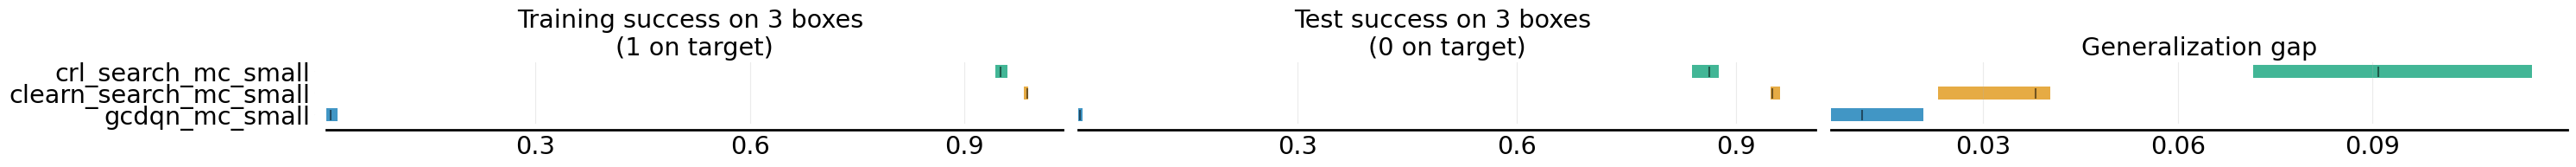

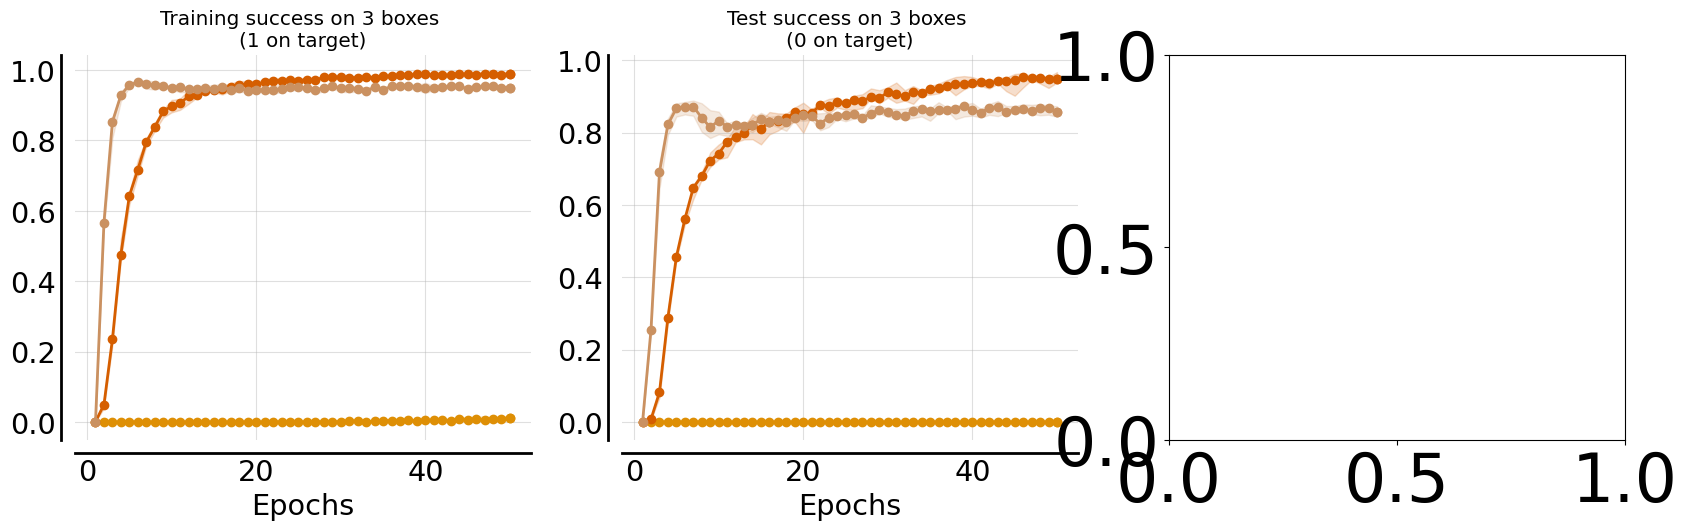

In [7]:
for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)

    empty_keys = []
    for k, v in data.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data[k]

    for k, v in data.items():
        diffs = (v[:, 0] - v[:, 1]).reshape(-1, 1)
        print(v.shape, diffs.shape)
        v = np.concatenate((v, diffs.reshape(-1, 1)), axis=1)
        data[k] = v
                     
    config['metrics']['eval/generalization_gap'] = "Generalization gap"

    names = list(data.keys())

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    draw_interval_estimates_plot(data, names, config['metrics'], config['title'], figures_path=path)
    draw_curves_plot(data_curves, config['possible_names'], config['metrics'], config['title'] + "_curves", figures_path=path)

(5, 2) (5, 1)
(5, 2) (5, 1)
(5, 2) (5, 1)
{'gcdqn_mc_small': array([[0.0234375 , 0.        , 0.0234375 ],
       [0.00878906, 0.00292969, 0.00585938],
       [0.01074219, 0.00292969, 0.0078125 ],
       [0.02636719, 0.00683594, 0.01953125],
       [0.0078125 , 0.00097656, 0.00683594]]), 'clearn_search_mc_small': array([[0.98144531, 0.96484375, 0.01660156],
       [0.98828125, 0.95019531, 0.03808594],
       [0.98828125, 0.94726562, 0.04101562],
       [0.98730469, 0.94726562, 0.04003906],
       [0.98632812, 0.95019531, 0.03613281]]), 'crl_search_mc_small': array([[0.95703125, 0.87792969, 0.07910156],
       [0.94628906, 0.86621094, 0.08007812],
       [0.94238281, 0.875     , 0.06738281],
       [0.9453125 , 0.83007812, 0.11523438],
       [0.96289062, 0.84960938, 0.11328125]])}
{'gcdqn_mc_small': array([[0.0234375 , 0.        , 0.0234375 ],
       [0.00878906, 0.00292969, 0.00585938],
       [0.01074219, 0.00292969, 0.0078125 ],
       [0.02636719, 0.00683594, 0.01953125],
       [0.

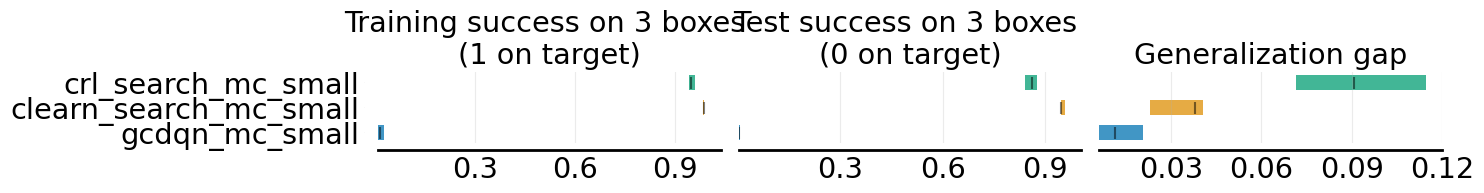

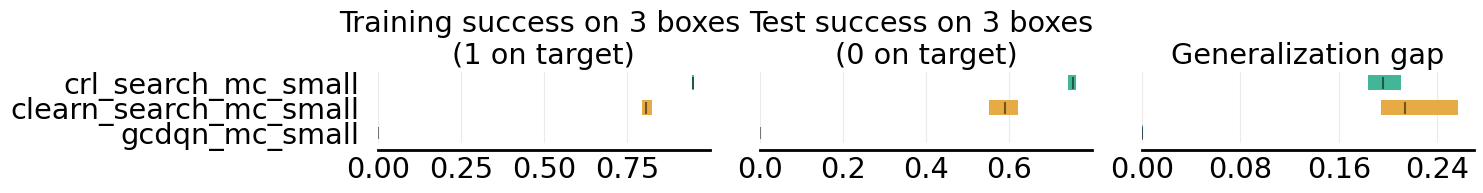

In [ ]:
for config in all_configs:
    runs = []
    for project in config['projects']:
        project_runs = api.runs(path=f"{entity}/{project}", filters=config['filters'])
        runs.extend([r for r in project_runs])


    data = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=True)
    data_curves = aggregate_data_from_wandb(runs, config['metrics'], config['possible_names'], config['grouping_func'], return_last_step=False)

    empty_keys = []
    for k, v in data.items():
        if v.size == 0:
            empty_keys.append(k)

    for k in empty_keys:
        del data[k]

    for k, v in data.items():
        diffs = (v[:, 0] - v[:, 1]).reshape(-1, 1)
        print(v.shape, diffs.shape)
        v = np.concatenate((v, diffs.reshape(-1, 1)), axis=1)
        data[k] = v
                     
    config['metrics']['eval/generalization_gap'] = "Generalization gap"

    names = list(data.keys())

    path = os.path.join(figures_path, config['directory'])
    os.makedirs(path, exist_ok=True)

    draw_interval_estimates_plot(data, names, config['metrics'], config['title'], figures_path=path)
    draw_curves_plot(data_curves, config['possible_names'], config['metrics'], config['title'] + "_curves", figures_path=path)